# Kernel density estimate with edge correction

We follow:

Kelsall, Diggle, "Non-parametric estimation of spatial variation in relative risk", Statistics in Medicine 14 (1995) 2335--2342

The idea is bias the density estimation near the boundary of a study region to reduce "edge effects".

We assume that we are using a fixed bandwidth, Gaussian KDE, of the form

$$ f(x) = \frac{1}{n} \sum_{i=1}^n \frac{1}{|S|^{1/2}} \frac{1}{h^2} K\big(h^{-2} (x-x_i)^T S^{-1} (x-x_i)\big)
\qquad (x\in\mathbb R^2), $$
where $K(t) = (2\pi)^{-1} e^{-t/2}$.  This is slightly more general than Kelsall and Diggle, as we allow a "covariance matrix" $S$.  The "edge corrected" estimate is
$$ \frac{f(x)}{q(x)} \quad\text{where}\quad q(x) = \int_A \frac{1}{|S|^{1/2}} \frac{1}{h^2} K\big(h^{-2} (x-y)^T S^{-1} (x-y)\big)
dy, $$
where $A$ is our study region.

Let us first [change variables](https://en.wikipedia.org/wiki/Integration_by_substitution#Substitution_for_multiple_variables)
\begin{align*} q(x) &=
\int_{S^{-1/2}A} \frac{1}{h^2} K\big(h^{-2} (x-S^{1/2}z)^T S^{-1} (x-S^{1/2}z)\big) dz, \\
&= \int_{S^{-1/2}A} \frac{1}{h^2} K\big(h^{-2} (S^{-1/2}x-z)^T (S^{-1/2}x-z)\big) dz \\
&= \int_{S^{-1/2}A} \frac{1}{2\pi h^2} e^{-\|(S^{-1/2}x-z)/h\|^2/2} dz.
\end{align*}

We can now follow Kelsall and Diggle.  Choose an integer $m$ and $r_1 < r_2 < \cdots < r_m$ with 
$$ \int_{0}^{r_i} \frac{1}{2\pi h^2} e^{-(r/h)^2/2} 2\pi r \ dr = \frac{i-1/2}{m}. $$
This is, we work in polar coordinates.  Notice that this integral can be evaluated exactly,
$$ \int_{0}^s \frac{1}{h^2} e^{-(r/h)^2/2} r \ dr = \int_{0}^s - \frac{d}{dr} e^{-(r/h)^2/2} \ dr
= 1 - e^{-(s/h)^2/2}, $$
and so
$$ r_i^2 = -2h^2 \log\Big( \frac{m - i + 1/2}{m} \Big). $$

Then we consider each circle of radius $r_i$ centred at $S^{-1/2}x$, and consider $k$ evenly spaced points on this circle.  Let $p(S^{-1/2}x, r_i)$ be the fraction of these $k$ points inside $S^{-1/2}A$.  Then,
$$ q(x) \approx \frac{1}{m} \sum_{i=1}^m p(S^{-1/2}x, r_i). $$
Recommended values are $m=10, k=100$.

**Unfortunately** this is rather slow.  See below for speed-ups.

# Example

In [1]:
import os, sys
sys.path.insert(0, os.path.abspath(os.path.join("..")))

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import shapely.geometry
import geopandas as gpd
import numpy as np
import descartes
import os
import open_cp.kernels
import open_cp.predictors
import open_cp.geometry

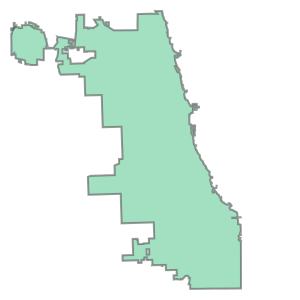

In [3]:
#datadir = os.path.join("/media", "disk", "Data")
datadir = os.path.join("..", "..", "..", "..", "Data")
chicago = gpd.GeoDataFrame.from_file(os.path.join(datadir, "Chicago_Areas.geojson"))
chicago.crs = {"init":"epsg:4326"}
chicago = chicago.to_crs({"init":"epsg:2790"}).geometry.unary_union
chicago

In [4]:
xmin, ymin, xmax, ymax = chicago.bounds
pts = np.random.random(size=(200,2)) * [xmax-xmin, ymax-ymin] + [xmin, ymin]
pts = shapely.geometry.MultiPoint(pts).intersection(chicago)
npts = np.asarray(pts).T

In [5]:
kernel = open_cp.kernels.GaussianEdgeCorrect(npts, chicago)

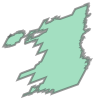

In [6]:
kernel.transformed_geometry

In [7]:
mask_grid = open_cp.geometry.mask_grid_by_intersection(chicago, open_cp.data.Grid(250,250,0,0))
grid_pred = open_cp.predictors.grid_prediction_from_kernel(kernel, mask_grid.region(), 250, samples=5)
grid_pred.mask_with(mask_grid)
grid_pred = grid_pred.renormalise()

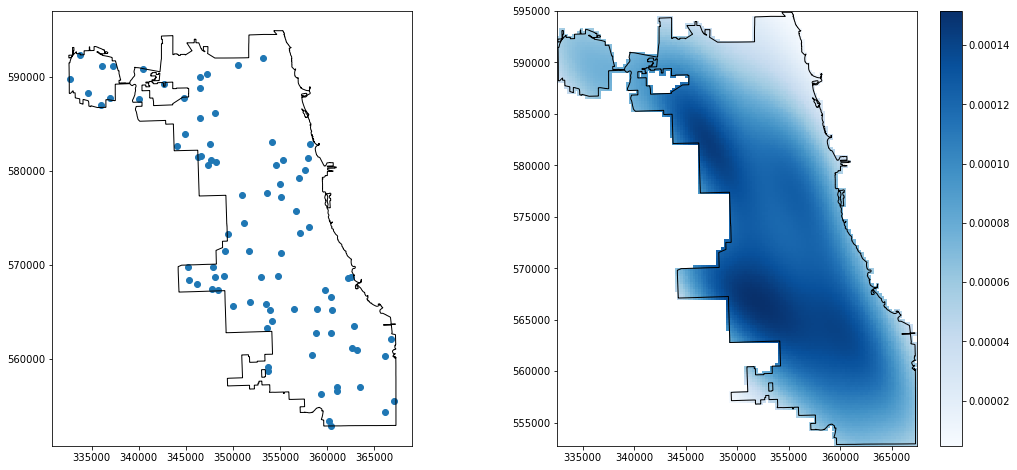

In [8]:
fig, axes = plt.subplots(ncols=2, figsize=(18,8))
for ax in axes:
    ax.add_patch(descartes.PolygonPatch(chicago, fc="none"))
    ax.set_aspect(1)
axes[0].scatter(*npts)
m = axes[1].pcolormesh(*grid_pred.mesh_data(), grid_pred.intensity_matrix, cmap="Blues")
plt.colorbar(m, ax=axes[1])
None

In [9]:
cf = dict()
for x in range(mask_grid.xextent):
    for y in range(mask_grid.yextent):
        if mask_grid.is_valid(x, y):
            xx = mask_grid.xoffset + (x + 0.5) * mask_grid.xsize
            yy = mask_grid.yoffset + (y + 0.5) * mask_grid.ysize
            cf[(x,y)] = kernel.correction_factor([xx, yy])

In [10]:
with_correction = grid_pred.clone()
for x in range(mask_grid.xextent):
    for y in range(mask_grid.yextent):
        if with_correction.is_valid(x, y):
            with_correction.intensity_matrix[y,x] /= cf[(x,y)]
with_correction = with_correction.renormalise()

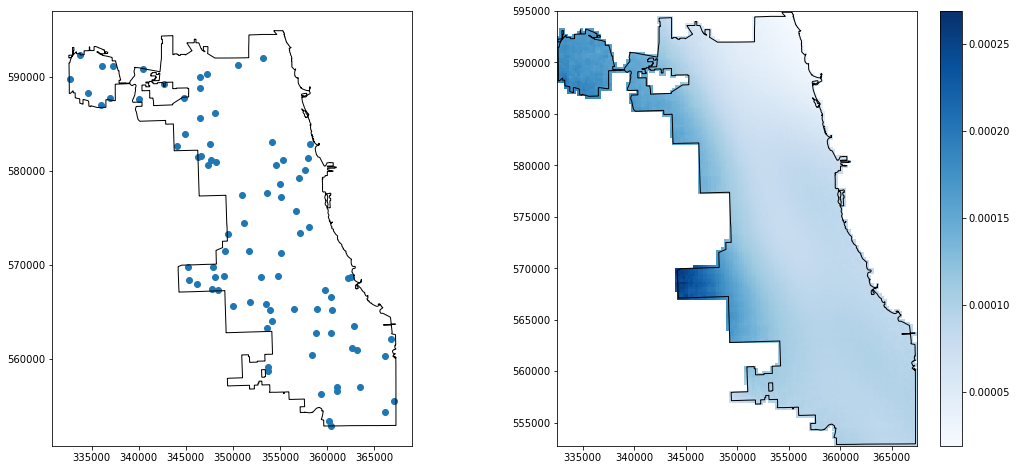

In [11]:
fig, axes = plt.subplots(ncols=2, figsize=(18,8))
for ax in axes:
    ax.add_patch(descartes.PolygonPatch(chicago, fc="none"))
    ax.set_aspect(1)
axes[0].scatter(*npts)
m = axes[1].pcolormesh(*with_correction.mesh_data(), with_correction.intensity_matrix, cmap="Blues")
plt.colorbar(m, ax=axes[1])
None

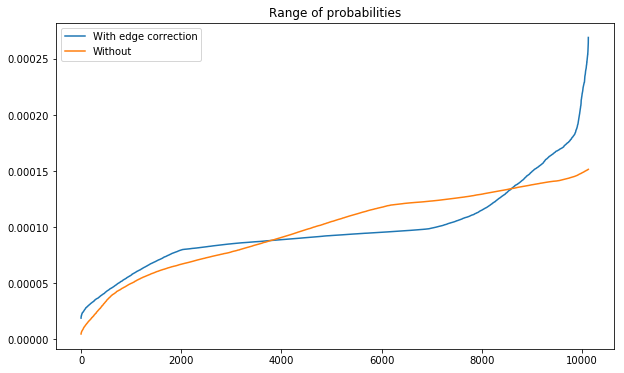

In [12]:
x = with_correction.intensity_matrix.flatten()
x = np.sort(x[~x.mask].data)
y = grid_pred.intensity_matrix.flatten()
y = np.sort(y[~y.mask].data)
fig, ax = plt.subplots(figsize=(10,6))
ax.plot(x, label="With edge correction")
ax.plot(y, label="Without")
ax.set(title="Range of probabilities")
ax.legend()
None

# On a grid

This form of edge correction is very slow (and we were only evaluating it once per grid cell).  Furthermore, in practise, we are intersted in a prediction on a grid, and the grid id clipped to the geometry only in the sense of including or omitting whole grid cells.

- That is, we really lose nothing by replacing the geometry with the outline of the "masked grid" we use.

Unfortunately, we still need to consider the covariance matrix $S$, and so the "transformed geometry" is a skewed grid.  However, we can transform the "sample points" back, and then intersect with the actual grid.

In [13]:
mask_grid = open_cp.geometry.mask_grid_by_intersection(chicago, open_cp.data.Grid(250,250,0,0))
kernel = open_cp.kernels.GaussianEdgeCorrectGrid(npts, mask_grid)

In [14]:
grid_pred1 = open_cp.predictors.grid_prediction_from_kernel_and_masked_grid(kernel, mask_grid, samples=5)
grid_pred1 = grid_pred1.renormalise()

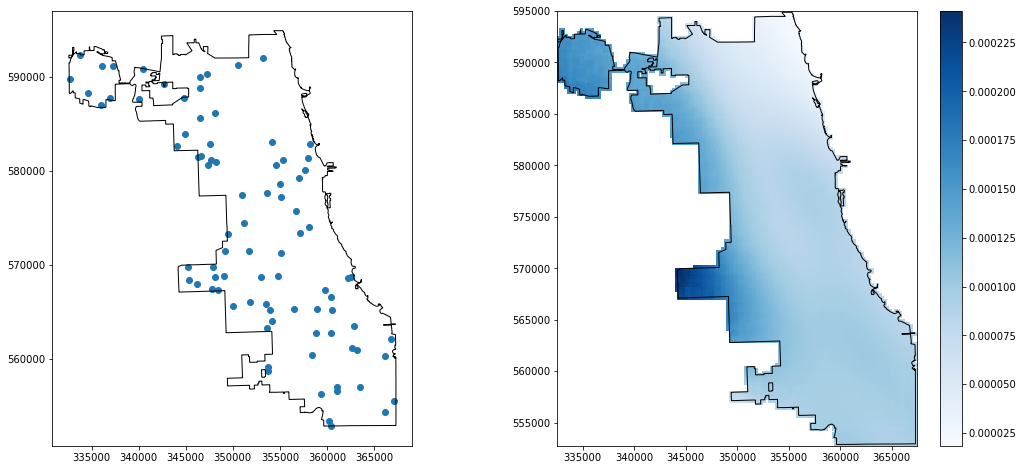

In [15]:
fig, axes = plt.subplots(ncols=2, figsize=(18,8))
for ax in axes:
    ax.add_patch(descartes.PolygonPatch(chicago, fc="none"))
    ax.set_aspect(1)
axes[0].scatter(*npts)
m = axes[1].pcolormesh(*grid_pred1.mesh_data(), grid_pred1.intensity_matrix, cmap="Blues")
plt.colorbar(m, ax=axes[1])
None

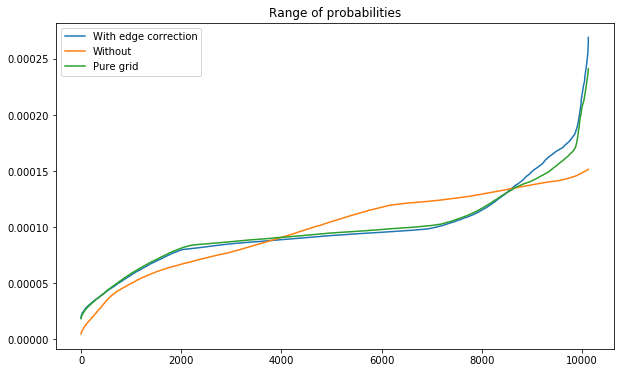

In [16]:
x = with_correction.intensity_matrix.flatten()
x = np.sort(x[~x.mask].data)
y = grid_pred.intensity_matrix.flatten()
y = np.sort(y[~y.mask].data)
z = grid_pred1.intensity_matrix.flatten()
z = np.sort(z[~z.mask].data)
fig, ax = plt.subplots(figsize=(10,6))
ax.plot(x, label="With edge correction")
ax.plot(y, label="Without")
ax.plot(z, label="Pure grid")
ax.set(title="Range of probabilities")
ax.legend()
None

Remember that this data is complete spatial randomness, so the ideal kernel should assign a constant probability to all grid cells.  We see that edge correction gets close to this ideal.